In [9]:
from scipy import ndimage
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import albumentations as albu
import glob
import cv2
from tqdm import tqdm
from skimage import feature, filters, color
from PIL import Image
import time

# Test

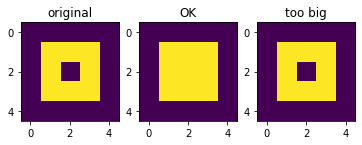

In [10]:
a = np.zeros((5, 5), dtype=int)
a[1:4, 1:4] = 1
a[2,2] = 0
ok = ndimage.binary_fill_holes(a).astype(int)
too_big = ndimage.binary_fill_holes(a, structure=np.ones((5,5))).astype(int)

plt.subplot(131), plt.imshow(a), plt.title('original')
plt.subplot(132), plt.imshow(ok), plt.title('OK')
plt.subplot(133), plt.imshow(too_big), plt.title('too big')
plt.show()

# On Eyeglasses

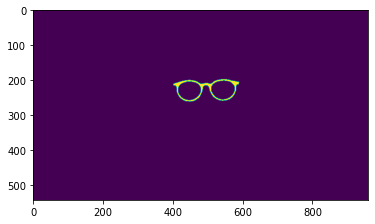

In [11]:
mask_path = os.path.join('C:\\Temp\\data\\mask_image_1\\0.png')
mask = np.array(Image.open(mask_path).convert('P'))
plt.imshow(mask)
plt.show()

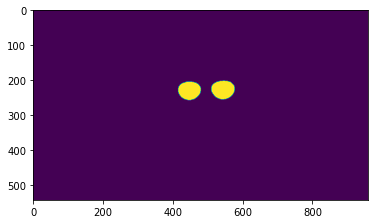

In [12]:
hole = mask - ndimage.binary_fill_holes(mask)
plt.imshow(hole)
plt.show()

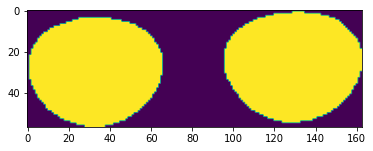

In [13]:
def crop_zone(zone):
    r, c = np.where(zone)
    bottom_left  = r.min()
    bottom_right = r.max()
    up_left      = c.min()
    up_right     = c.max()
    zone_cropped = zone[bottom_left-1:bottom_right+1,up_left-1:up_right+1]
    return zone_cropped

window_hole = crop_zone(hole)
plt.imshow(window_hole)
plt.show()

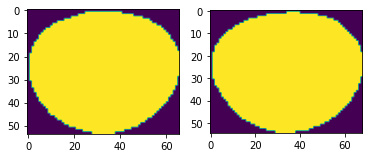

In [14]:
r, c = np.where(window_hole)
bottom_left  = r.min()
bottom_right = r.max()
up_left      = c.min()
up_right     = c.max()
middle     = int(np.mean(c))
left_hole  = window_hole[bottom_left-1:bottom_right+1,up_left-1:middle+1]
right_hole = window_hole[bottom_left-1:bottom_right+1,middle-1:up_right+1]

plt.subplot(121), plt.imshow(crop_zone(left_hole))
plt.subplot(122), plt.imshow(crop_zone(right_hole))
plt.show()

# create function 

In [15]:
def get_boxing(mask):
    left_hole  = np.zeros(mask.shape)
    right_hole = np.zeros(mask.shape)
    # get hole in frame
    hole = mask - ndimage.binary_fill_holes(mask)
    # split in 2 with middle point
    r, c = np.where(hole)
    m    = int(np.mean(c))
    left_hole[:,:m+1]  = hole[:,:m+1]
    right_hole[:,m+1:] = hole[:,m+1:]
    # get boxing for each
    r, c   = np.where(left_hole)
    bl, br = r.min()-1, r.max()+1
    ul, ur = c.min()-1, c.max()+1
    left_boxing = (bl, br, ul, ur)
    r, c   = np.where(right_hole)
    bl, br = r.min()-1, r.max()+1
    ul, ur = c.min()-1, c.max()+1
    right_boxing = (bl, br, ul, ur)
    return left_boxing, right_boxing

# Plot boxing on video

In [16]:
input_size = (544,960)

In [17]:
image_folder = 'C:\\Temp\\data\\video_image_1\\'
mask_folder  = 'C:\\Temp\\data\\mask_image_1\\'
# get image
images = glob.glob(os.path.join(image_folder,"*.jpg"))
masks  = glob.glob(os.path.join(mask_folder,"*.png"))
# create video object
video_name   = 'C:\\Temp\\data\\video_boxing_1.avi'
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
video  = cv2.VideoWriter(video_name, fourcc, 20, (input_size[1],input_size[0]))

In [20]:
# loop on image
for i, _ in enumerate(tqdm(images)):
    img = plt.imread(os.path.join(image_folder, str(i)+".jpg"))
    mask_path  = os.path.join(mask_folder, str(i)+'.png')
    mask       = np.array(Image.open(mask_path).convert('P'))
    img        = cv2.resize(img, (input_size[1],input_size[0]))
    left_boxing, right_boxing = get_boxing(mask)
    (bl, br, ul, ur) = left_boxing
    img[bl:br,ul] = (0,0,255)
    img[bl:br,ur] = (0,0,255)
    img[bl,ul:ur] = (0,0,255)
    img[br,ul:ur] = (0,0,255)
    (bl, br, ul, ur) = right_boxing
    img[bl:br,ul] = (0,0,255)
    img[bl:br,ur] = (0,0,255)
    img[bl,ul:ur] = (0,0,255)
    img[br,ul:ur] = (0,0,255)
    video.write(cv2.cvtColor(img,cv2.COLOR_RGB2BGR))
    #time.sleep(0.001)

video.release()

100%|████████████████████████████████████████████████████████████████████████████████| 513/513 [00:43<00:00, 11.86it/s]


# Plot Edges on video

In [21]:
image_folder = 'C:\\Temp\\data\\video_image_1\\'
mask_folder  = 'C:\\Temp\\data\\mask_image_1\\'
# get image
images = glob.glob(os.path.join(image_folder,"*.jpg"))
masks  = glob.glob(os.path.join(mask_folder,"*.png"))
# create video object
video_name   = 'C:\\Temp\\data\\video_edges_1.avi'
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
video  = cv2.VideoWriter(video_name, fourcc, 20, (input_size[1],input_size[0]))
# loop on image
for i, _ in enumerate(tqdm(images)):
    img = plt.imread(os.path.join(image_folder, str(i)+".jpg"))
    mask_path  = os.path.join(mask_folder, str(i)+'.png')
    mask       = np.array(Image.open(mask_path).convert('P'))
    img        = cv2.resize(img, (input_size[1],input_size[0]))
    hole       = mask - ndimage.binary_fill_holes(mask)
    edges      = feature.canny(hole)
    image_mean = np.mean(img,axis=2)
    image_mean = np.repeat(image_mean[:, :, np.newaxis], 3, axis=2).astype('uint8')
    image_mean[edges] = [255,0,0]

    video.write(cv2.cvtColor(image_mean,cv2.COLOR_RGB2BGR))

video.release()

100%|████████████████████████████████████████████████████████████████████████████████| 513/513 [01:39<00:00,  5.18it/s]


# Plot Fitting Height

In [10]:
import dlib
detector  = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

In [11]:
image_folder = 'C:\\Temp\\data\\video_image_1\\'
mask_folder  = 'C:\\Temp\\data\\mask_image_1\\'
fig_folder   = 'C:\\Temp\\data\\fig_image_1\\'
# get image
images = glob.glob(os.path.join(image_folder,"*.jpg"))
masks  = glob.glob(os.path.join(mask_folder,"*.png"))
# create video object
video_name   = 'C:\\Temp\\data\\video_FH_1.avi'
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
video  = cv2.VideoWriter(video_name, fourcc, 20, (input_size[1],input_size[0]))

In [89]:
#PD_px = x_right-x_left
#PD_mm = 63.5
#ratio = PD_px/PD_mm
ratio = 1.37

In [103]:
# loop on image
for i, _ in enumerate(tqdm(images)):
    img = plt.imread(os.path.join(image_folder, str(i)+".jpg"))
    mask_path  = os.path.join(mask_folder, str(i)+'.png')
    mask       = np.array(Image.open(mask_path).convert('P'))
    img        = cv2.resize(img, (input_size[1],input_size[0]))
    # Boxing
    left_boxing, right_boxing = get_boxing(mask)
    # FH
    faces_in_image = detector(img, 0)
    landmarks = predictor(img, faces_in_image[0])
    x,y=[],[]
    for k in [37,38,40,41]: # left eye
        x.append(landmarks.part(k).x)
        y.append(landmarks.part(k).y)
    x_left, y_left = int(np.mean(x)), int(np.mean(y))
    x,y=[],[]
    for k in [43,44,46,47]: # left eye
        x.append(landmarks.part(k).x)
        y.append(landmarks.part(k).y)
    x_right, y_right = int(np.mean(x)), int(np.mean(y))
    # measurement
    if (i%10 == 0):
        (bl, br, ul, ur) = left_boxing
        FH_px_left       = br-y_left
        FH_mm_left       = FH_px_left*ratio
        text_FH_mm_left  = "{:.2f} mm".format(FH_mm_left)
        (bl, br, ul, ur) = right_boxing
        FH_px_right      = br-y_right
        FH_mm_right      = FH_px_right*ratio
        text_FH_mm_right = "{:.2f} mm".format(FH_mm_right)    
    # Color image
    (bl, br, ul, ur) = left_boxing
    img[y_left:br,x_left] = (0,0,255)
    img[bl:br,ul] = (0,0,255)
    img[bl:br,ur] = (0,0,255)
    img[bl,ul:ur] = (0,0,255)
    img[br,ul:ur] = (0,0,255)
    (bl, br, ul, ur) = right_boxing
    img[y_right:br,x_right] = (0,0,255)
    img[bl:br,ul] = (0,0,255)
    img[bl:br,ur] = (0,0,255)
    img[bl,ul:ur] = (0,0,255)
    img[br,ul:ur] = (0,0,255)
    plt.figure(figsize=(20,10))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    plt.imshow(img)
    plt.text(750, 75, 'FH left   = '+text_FH_mm_left + '\nFH right = '+text_FH_mm_right, bbox=props, fontsize=17) 
    plt.savefig(os.path.join(fig_folder,str(i)+".jpg"))
    #video.write(cv2.cvtColor(img,cv2.COLOR_RGB2BGR))
    plt.close()

video.release()

100%|████████████████████████████████████████████████████████████████████████████████| 513/513 [10:00<00:00,  1.17s/it]


In [5]:
# create video object
video_name   = 'C:\\Temp\\data\\video_FH_3.avi'
fig_folder   = 'C:\\Temp\\data\\fig_image_1\\'
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
video  = cv2.VideoWriter(video_name, fourcc, 20, (img.shape[1],img.shape[0]))

In [6]:
# loop on image
images = glob.glob(os.path.join(fig_folder,"*.jpg"))
for i, _ in enumerate(tqdm(images)):
    img = plt.imread(os.path.join(fig_folder, str(i)+".jpg"))
    video.write(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

video.release()

100%|████████████████████████████████████████████████████████████████████████████████| 513/513 [00:11<00:00, 43.76it/s]


# Full boxing

In [ ]:
# Color image
(bl, br, ul, ur) = left_boxing
#img[y_left,ul:x_left] = (0,0,255)
#img[y_left,x_left:ur] = (0,0,255)
img[y_left:br,x_left] = (0,0,255)
#img[bl:y_left,x_left] = (0,0,255)
img[bl:br,ul] = (0,0,255)
img[bl:br,ur] = (0,0,255)
img[bl,ul:ur] = (0,0,255)
img[br,ul:ur] = (0,0,255)
(bl, br, ul, ur) = right_boxing
#img[y_right,ul:x_right] = (0,0,255)
#img[y_right,x_right:ur] = (0,0,255)
img[y_right:br,x_right] = (0,0,255)
#img[bl:y_right,x_right] = (0,0,255)
img[bl:br,ul] = (0,0,255)
img[bl:br,ur] = (0,0,255)
img[bl,ul:ur] = (0,0,255)
img[br,ul:ur] = (0,0,255)

# Display "teinte" inside frame

In [18]:
def colorize(image, mask, hue=0.5, saturation=1, value=0):
    hsv = color.rgb2hsv(image)
    if hue:
        hsv[mask, 0] = hue
    if value:
        hsv[mask, 2] = hsv[mask, 2] - value
    if saturation:
        hsv[mask, 1] = saturation
    return color.hsv2rgb(hsv)

In [19]:
image_folder = 'C:\\Temp\\data\\video_image_1\\'
mask_folder  = 'C:\\Temp\\data\\mask_image_1\\'
# get image
images = glob.glob(os.path.join(image_folder,"*.jpg"))
masks  = glob.glob(os.path.join(mask_folder,"*.png"))
# create video object
video_name   = 'C:\\Temp\\data\\video_teinte_1.avi'
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
video  = cv2.VideoWriter(video_name, fourcc, 20, (input_size[1],input_size[0]))

In [22]:
# loop on image
k = 0
for i, _ in enumerate(tqdm(images)):
    img = plt.imread(os.path.join(image_folder, str(i)+".jpg"))
    mask_path  = os.path.join(mask_folder, str(i)+'.png')
    mask       = np.array(Image.open(mask_path).convert('P'))
    img        = cv2.resize(img, (input_size[1],input_size[0]))
    hole       = (mask - ndimage.binary_fill_holes(mask)).astype(bool)
    # change grayscale tint
    if i <= 125:
        img = colorize(img, hole, hue=None, saturation=None, value=val_list[k])
    if (i > 125) and (i <= 250):
        img = colorize(img, hole, hue=None, saturation=None, value=val_list[-k])
    # change hue tint
    if (i > 250):
        img = colorize(img, hole, hue=hue_list[k], saturation=None, value=None)
    # format image
    img = np.clip(img, 0, 1)
    img = (img*255).astype('uint8')
    # update counter
    if (i==125) or (i==250):
        k = 1
    else:
        k = k + 1
    
    video.write(cv2.cvtColor(img,cv2.COLOR_RGB2BGR))

video.release()

100%|████████████████████████████████████████████████████████████████████████████████| 513/513 [03:33<00:00,  2.40it/s]


In [28]:
img = plt.imread(os.path.join(image_folder, str(i)+".jpg"))
mask_path  = os.path.join(mask_folder, str(i)+'.png')
mask       = np.array(Image.open(mask_path).convert('P'))
img        = cv2.resize(img, (input_size[1],input_size[0]))
t = time.time()
hole       = (mask - ndimage.binary_fill_holes(mask)).astype(bool)
img = colorize(img, hole, hue=None, saturation=None, value=val_list[0])
time.time() - t 

0.5962481498718262

## change hue

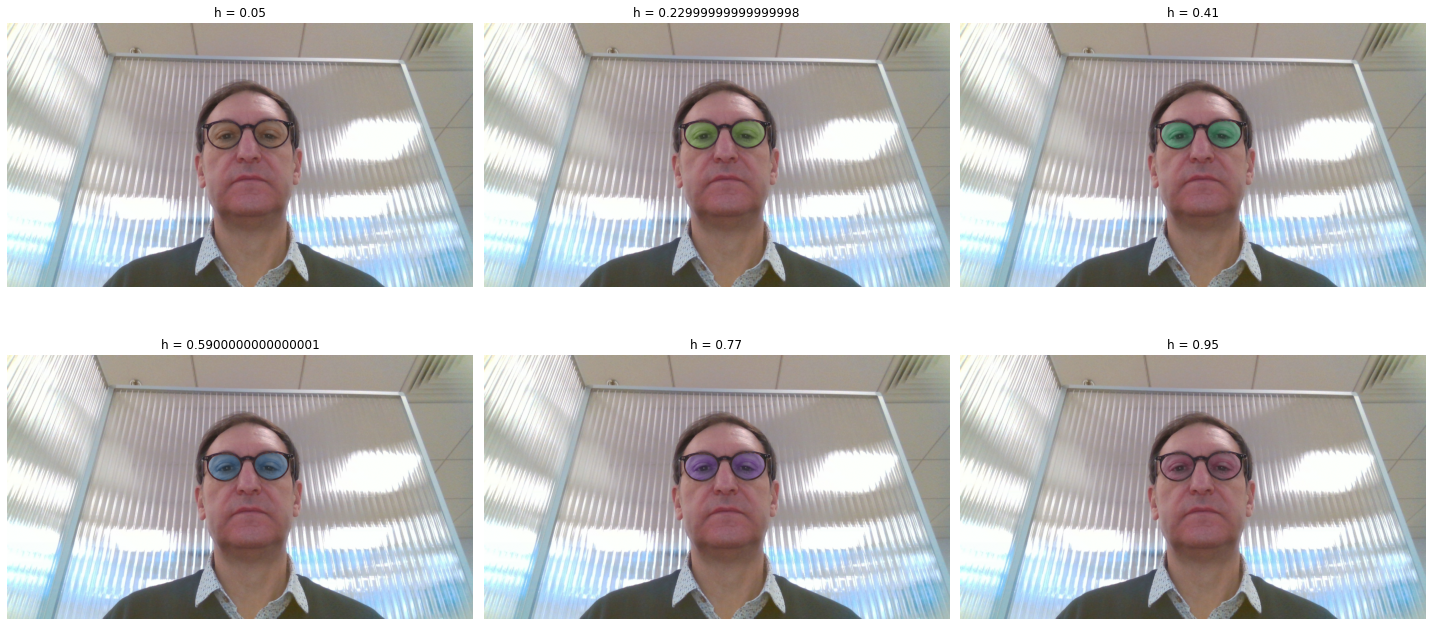

In [208]:
hue_rotations   = np.linspace(0.05, 0.95, 6)
fig, axes       = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(20,10))
for ax, hue in zip(axes.flat, hue_rotations):
    tinted_image = colorize(img, hole, hue=hue, saturation=None)
    ax.imshow(tinted_image, vmin=0, vmax=1)
    ax.set_axis_off()
    ax.set_title("h = "+str(hue))
fig.tight_layout()

## change saturations

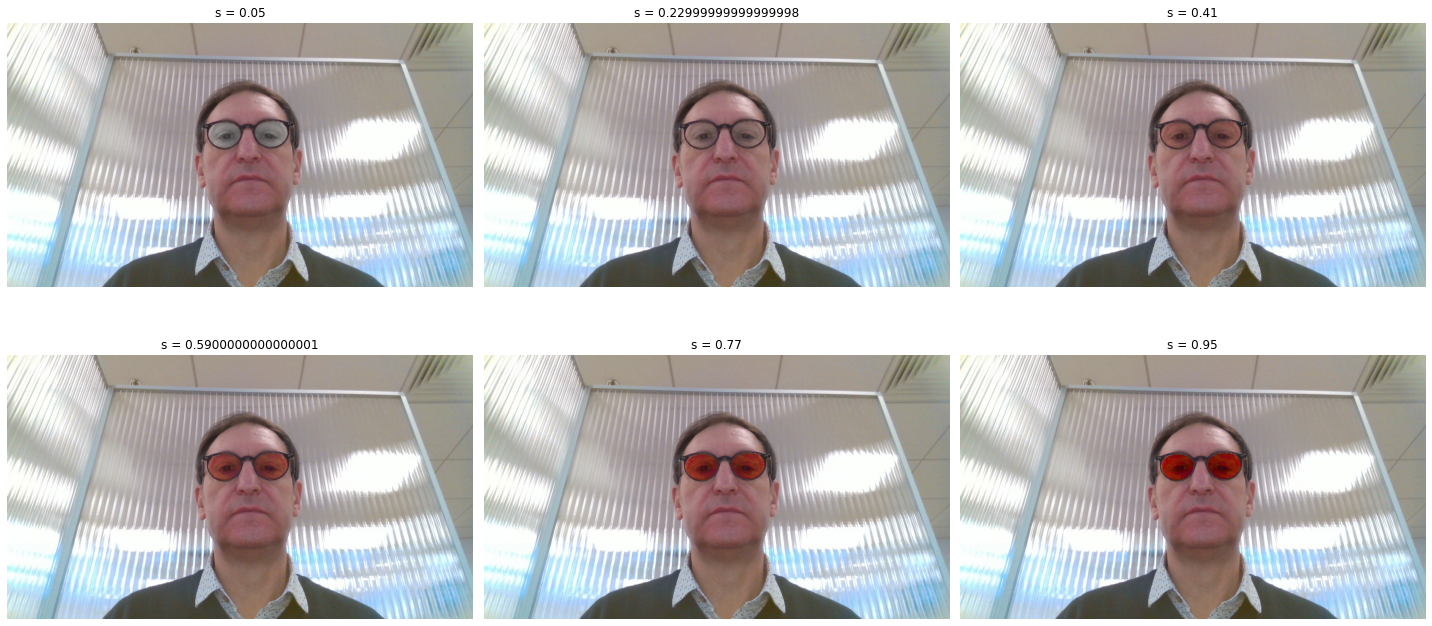

In [174]:
saturation_rotations = np.linspace(0.05, 0.95, 6)
fig, axes            = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(20,10))
for ax, sat in zip(axes.flat, saturation_rotations):
    tinted_image = colorize(img, hole, hue=None, saturation=sat)
    ax.imshow(tinted_image, vmin=0, vmax=1)
    ax.set_axis_off()
    ax.set_title("s = "+str(sat))
fig.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


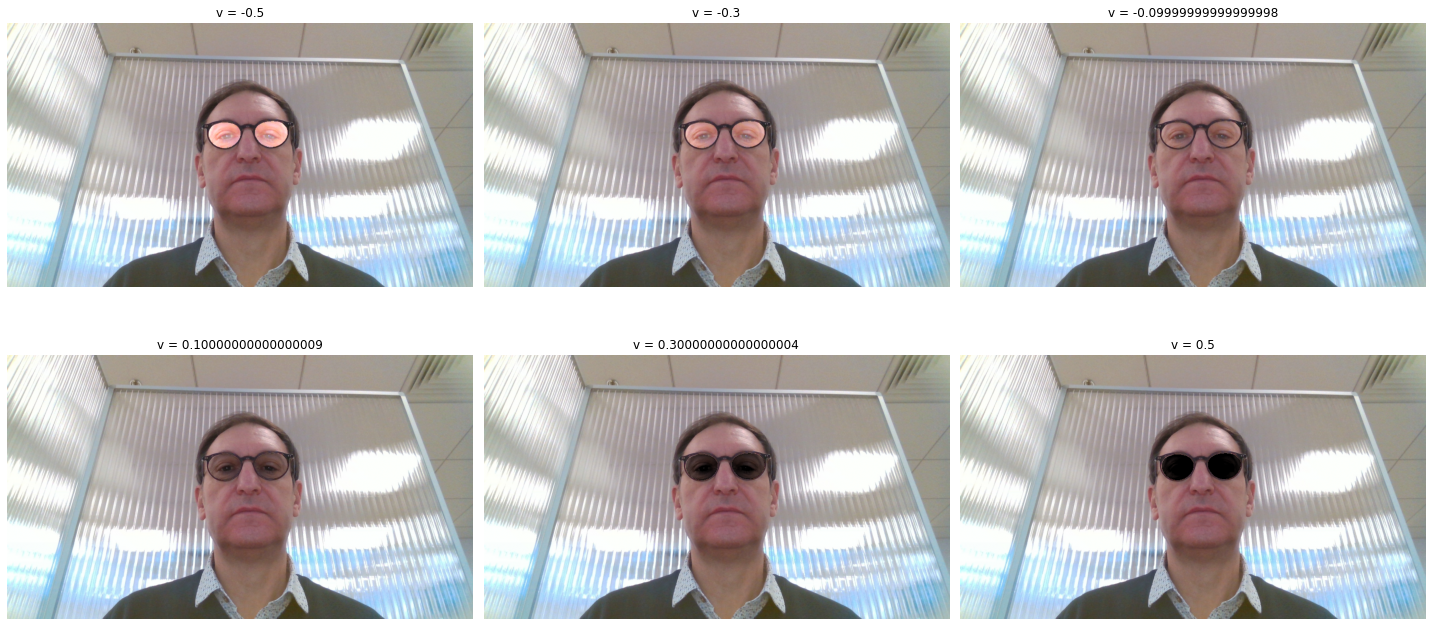

In [207]:
value_rotations = np.linspace(-0.5, 0.5, 6)
fig, axes       = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(20,10))
for ax, val in zip(axes.flat, value_rotations):
    tinted_image = colorize(img, hole, hue=None, saturation=None, value=val)
    ax.imshow(tinted_image, vmin=0, vmax=1)
    ax.set_axis_off()
    ax.set_title("v = "+str(val))
fig.tight_layout()